**Nama : Akbar Ariffianto**

#Import Libraries

In [5]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

from tqdm import tqdm
tqdm.pandas()

import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
nltk.download('punkt_tab') # Download punkt_tab

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE

from joblib import dump

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#Load Dataset

In [6]:
ml_review = pd.read_csv("/content/mobileLegend_feedback_balanced.csv")

In [7]:
ml_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  12000 non-null  object
 1   Score   12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [8]:
ml_review.head()

,Review,Score
0,Saya merasa sangat kesal ketika sedang bermain...,5
1,"Aplikasi macam apa ini,sinyal tidak stabil pad...",5
2,"""Sebenernya Mobile Legends tuh game-nya seru b...",5
3,"Haloo min MLBB, sebelumnya mau kasih ulasan ka...",5
4,game nya memang bagus event nya juga menarik t...,5


#Handling Null and Duplicate Data

In [9]:
ml_review.isnull().sum()

,0
Review,0
Score,0


In [10]:
ml_review.duplicated().sum()

np.int64(0)

In [11]:
clean_df = ml_review.dropna().drop_duplicates()

In [12]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  12000 non-null  object
 1   Score   12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


# Preprocess



In [13]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def cleaningText(text):
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [14]:
slangwords = {
    "@": "di",
    "abis": "habis",
    "wtb": "beli",
    "masi": "masih",
    "wts": "jual",
    "wtt": "tukar",
    "bgt": "banget",
    "maks": "maksimal",
    "gws": "semoga cepat sembuh",
    "lol": "tertawa keras",
    "btw": "ngomong-ngomong",
    "cmiiw": "correct me if I'm wrong",
    "oot": "out of topic",
    "brb": "segera kembali",
    "thx": "terima kasih",
    "kuy": "yuk",
    "gokil": "gila",
    "mantul": "mantap betul",
    "kece": "keren",
    "sokap": "siapa",
    "cem": "macam",
    "gabut": "gaji buta",
    "baper": "bawa perasaan",
    "jir": "anjir",
    "cape": "capek",
    "santuy": "santai",
    "gaje": "gak jelas",
    "nongki": "nongkrong",
    "bt": "bosan tuch",
    "skuy": "sikat yuk",
    "dih": "sih",
    "wkwk": "tertawa (laughing)",
    "php": "pemberi harapan palsu",
    "gils": "gila",
    "jomblo": "single",
    "kode": "memberi isyarat",
    "lelet": "lambat",
    "modar": "mati",
    "ngab": "bro",
    "njem": "bosan",
    "ogah": "males",
    "pleg": "playgroup",
    "sotoy": "sok tahu",
    "temen": "teman",
    "uwu": "imut",
    "war": "perang (biasanya di game)",
    "zonk": "gagal",
    "bucin": "budak cinta",
    "cans": "cantik",
    "gans": "ganteng",
    "jem": "jam",
    "kzl": "kesal",
    "maksi": "makan siang",
    "mager": "males gerak",
    "ngg": "enggak",
    "nt": "nice try",
    "panik": "panik",
    "ribet": "rumit",
    "salty": "kesal atau jengkel",
    "sus": "susah",
    "tretan": "teman",
    "vibes": "suasana",
    "ygy": "ya gitu yah",
    "zuzur": "jujur"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [15]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

#Labelling

In [31]:
import pandas as pd

emotion_lexicon = {}
try:
    with open('Indonesian-NRC-EmoLex.txt', 'r', encoding='utf-8') as file:
        next(file)
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 12:
                indonesian_word = parts[11]
                scores = {
                    'anger': int(parts[1]),
                    'joy': int(parts[5]),
                    'negative': int(parts[6]),
                    'positive': int(parts[7]),
                    'sadness': int(parts[8]),
                    'surprise': int(parts[9]),
                }
                emotion_lexicon[indonesian_word] = scores
except FileNotFoundError:
    print("Error: 'Indonesian-NRC-EmoLex.txt' tidak ditemukan.")
    exit()

def analyze_emotion(tokens):
    emotion_scores = {
        'anger': 0, 'joy': 0, 'negative': 0, 'positive': 0,
        'sadness': 0, 'surprise': 0
    }
    for word in tokens:
        if word in emotion_lexicon:
            for emotion, score in emotion_lexicon[word].items():
                if score == 1:
                    emotion_scores[emotion] += 1
    return emotion_scores

In [32]:
emotion_results = clean_df['text_stopword'].apply(analyze_emotion)
df_emotion = pd.DataFrame(emotion_results.tolist(), index=clean_df.index)

df_final = pd.concat([clean_df, df_emotion], axis=1)

In [33]:
df_final.head(10)

,Review,Score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,anger,joy,negative,positive,sadness,surprise
0,Saya merasa sangat kesal ketika sedang bermain...,5,Saya merasa sangat kesal ketika sedang bermain...,saya merasa sangat kesal ketika sedang bermain...,saya merasa sangat kesal ketika sedang bermain...,"[saya, merasa, sangat, kesal, ketika, sedang, ...","[kesal, bermain, sengaja, terkeluarkan, aplika...",kesal bermain sengaja terkeluarkan aplikasi ma...,0,0,0,0,0,0
1,"Aplikasi macam apa ini,sinyal tidak stabil pad...",5,Aplikasi macam apa inisinyal tidak stabil pada...,aplikasi macam apa inisinyal tidak stabil pada...,aplikasi macam apa inisinyal tidak stabil pada...,"[aplikasi, macam, apa, inisinyal, tidak, stabi...","[aplikasi, inisinyal, stabil, ping, wifi, bagu...",aplikasi inisinyal stabil ping wifi bagussaya ...,1,0,3,0,1,1
2,"""Sebenernya Mobile Legends tuh game-nya seru b...",5,Sebenernya Mobile Legends tuh gamenya seru ban...,sebenernya mobile legends tuh gamenya seru ban...,sebenernya mobile legends tuh gamenya seru ban...,"[sebenernya, mobile, legends, tuh, gamenya, se...","[sebenernya, mobile, legends, tuh, gamenya, se...",sebenernya mobile legends tuh gamenya seru ban...,1,2,1,2,2,0
3,"Haloo min MLBB, sebelumnya mau kasih ulasan ka...",5,Haloo min MLBB sebelumnya mau kasih ulasan kal...,haloo min mlbb sebelumnya mau kasih ulasan kal...,haloo min mlbb sebelumnya mau kasih ulasan kal...,"[haloo, min, mlbb, sebelumnya, mau, kasih, ula...","[haloo, min, mlbb, kasih, ulasan, kalo, gameny...",haloo min mlbb kasih ulasan kalo gamenya udah ...,0,2,0,2,0,2
4,game nya memang bagus event nya juga menarik t...,5,game nya memang bagus event nya juga menarik t...,game nya memang bagus event nya juga menarik t...,game nya memang bagus event nya juga menarik t...,"[game, nya, memang, bagus, event, nya, juga, m...","[game, bagus, event, menarik, sayang, mech, ma...",game bagus event menarik sayang mech making pl...,1,2,3,3,3,1
5,mohon dimudahkan dalam permainan agar mudah me...,5,mohon dimudahkan dalam permainan agar mudah me...,mohon dimudahkan dalam permainan agar mudah me...,mohon dimudahkan dalam permainan agar mudah me...,"[mohon, dimudahkan, dalam, permainan, agar, mu...","[mohon, dimudahkan, permainan, mudah, mencapai...",mohon dimudahkan permainan mudah mencapai rank...,0,1,2,5,0,0
6,Saya ingin menyampaikan saran terkait fitur ha...,5,Saya ingin menyampaikan saran terkait fitur ha...,saya ingin menyampaikan saran terkait fitur ha...,saya ingin menyampaikan saran terkait fitur ha...,"[saya, ingin, menyampaikan, saran, terkait, fi...","[saran, terkait, fitur, hadiah, kolektor, jura...",saran terkait fitur hadiah kolektor juragan v ...,0,2,3,4,1,2
7,"saat udh menang 3x dikasih dari system, punya ...",4,saat udh menang x dikasih dari system punya ti...,saat udh menang x dikasih dari system punya ti...,saat udh menang x dikasih dari system punya ti...,"[saat, udh, menang, x, dikasih, dari, system, ...","[udh, menang, x, dikasih, system, tim, acakaca...",udh menang x dikasih system tim acakacakan mat...,2,2,3,4,0,1
8,"""MOONTON TOLONG PERBAIKI MLBB"" dari kemarin sa...",5,MOONTON TOLONG PERBAIKI MLBB dari kemarin saya...,moonton tolong perbaiki mlbb dari kemarin saya...,moonton tolong perbaiki mlbb dari kemarin saya...,"[moonton, tolong, perbaiki, mlbb, dari, kemari...","[moonton, tolong, perbaiki, mlbb, kemarin, log...",moonton tolong perbaiki mlbb kemarin login mat...,1,1,2,3,1,1
9,"game nya bagus,tapi tolong lah monton jaringan...",5,game nya bagustapi tolong lah monton jaringan ...,game nya bagustapi tolong lah monton jaringan ...,game nya bagustapi tolong lah monton jaringan ...,"[game, nya, bagustapi, tolong, lah, monton, ja...","[game, bagustapi, tolong, monton, jaringan, pe...",game bagustapi tolong monton jaringan perbaiki...,1,0,1,0,1,0


In [35]:
def get_dominant_emotion_single(row):
    emotion_scores = {
        'anger': row['anger'],
        'joy': row['joy'],
        'sadness': row['sadness'],
        'surprise': row['surprise']
    }

    max_score = max(emotion_scores.values())

    if max_score == 0:
        return 'netral'

    dominant_emotions = [
        emotion for emotion, score in emotion_scores.items() if score == max_score
    ]

    return dominant_emotions[0]

df_final['dominant_emotion'] = df_emotion.apply(get_dominant_emotion_single, axis=1)
print(df_final[['Review', 'dominant_emotion']].head())

                                              Review dominant_emotion
0  Saya merasa sangat kesal ketika sedang bermain...           netral
1  Aplikasi macam apa ini,sinyal tidak stabil pad...            anger
2  "Sebenernya Mobile Legends tuh game-nya seru b...              joy
3  Haloo min MLBB, sebelumnya mau kasih ulasan ka...              joy
4  game nya memang bagus event nya juga menarik t...          sadness


# EDA

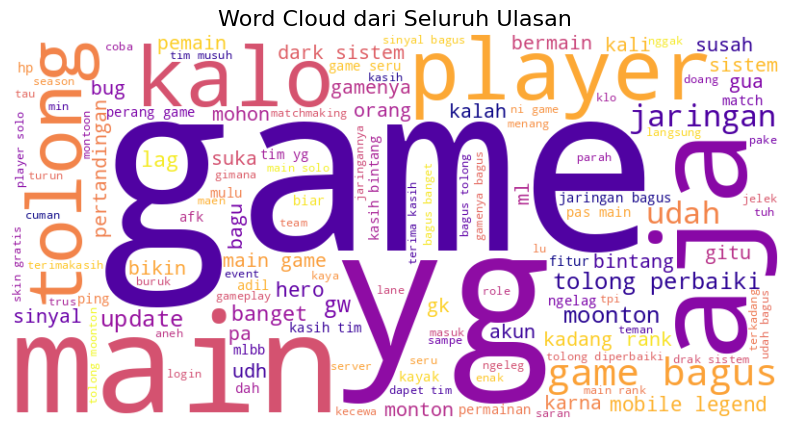

In [36]:
all_words = ' '.join([' '.join(tokens) for tokens in df_final['text_stopword']])

wordcloud_all = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='plasma',
                          min_font_size=10).generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Seluruh Ulasan', fontsize=16)
plt.show()

# Splitting Data

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df_final['text_akhir']
y = df_final['dominant_emotion']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=100,
    stratify=y
)

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))

Jumlah data latih: 9600
Jumlah data uji: 2400


# Ekstraksi Fitur (TF-IDF)

In [38]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)

X_test_tfidf = tfidf.transform(X_test)

print("\n--- Setelah Ekstraksi Fitur TF-IDF ---")
print("Dimensi matriks data latih:", X_train_tfidf.shape)
print("Dimensi matriks data uji:", X_test_tfidf.shape)


--- Setelah Ekstraksi Fitur TF-IDF ---
Dimensi matriks data latih: (9600, 5000)
Dimensi matriks data uji: (2400, 5000)


# Modelling

In [45]:
from sklearn.metrics import classification_report, accuracy_score

accuracy_summary = {}

## Naive Bayes

In [46]:
from sklearn.naive_bayes import BernoulliNB

# Inisialisasi model Naive Bayes (Bernoulli Naive Bayes cocok untuk data TF-IDF)
model_nb = BernoulliNB()

# Melatih model
model_nb.fit(X_train_tfidf, y_train)

# Memprediksi pada data uji
y_pred_nb = model_nb.predict(X_test_tfidf)

# Naive Bayes
y_train_pred_nb = model_nb.predict(X_train_tfidf)
accuracy_summary['Naive Bayes'] = {
    'Train Accuracy': accuracy_score(y_train, y_train_pred_nb),
    'Test Accuracy': accuracy_score(y_test, y_pred_nb)
}

# Evaluasi model
print("--- Naive Bayes Model Evaluation ---")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

--- Naive Bayes Model Evaluation ---
              precision    recall  f1-score   support

       anger       0.72      0.73      0.72       779
         joy       0.75      0.82      0.78       901
      netral       0.79      0.79      0.79       520
     sadness       0.45      0.23      0.30       131
    surprise       0.26      0.12      0.16        69

    accuracy                           0.73      2400
   macro avg       0.59      0.54      0.55      2400
weighted avg       0.72      0.73      0.72      2400

Accuracy: 0.7316666666666667


## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest
model_rf = RandomForestClassifier(random_state=seed)

# Melatih model
model_rf.fit(X_train_tfidf, y_train)

# Memprediksi pada data uji
y_pred_rf = model_rf.predict(X_test_tfidf)

# Random Forest
y_train_pred_rf = model_rf.predict(X_train_tfidf)
accuracy_summary['Random Forest'] = {
    'Train Accuracy': accuracy_score(y_train, y_train_pred_rf),
    'Test Accuracy': accuracy_score(y_test, y_pred_rf)
}

# Evaluasi model
print("---Random Forest Model Evaluation ---")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

---Random Forest Model Evaluation ---
              precision    recall  f1-score   support

       anger       0.85      0.84      0.85       779
         joy       0.88      0.89      0.89       901
      netral       0.80      0.99      0.88       520
     sadness       0.83      0.30      0.44       131
    surprise       0.90      0.41      0.56        69

    accuracy                           0.85      2400
   macro avg       0.85      0.68      0.72      2400
weighted avg       0.85      0.85      0.84      2400

Accuracy: 0.84875


## XGBoost

In [48]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

model_xgb_encoded = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=seed)
model_xgb_encoded.fit(X_train_tfidf, y_train_encoded)

y_train_pred_xgb_encoded = model_xgb_encoded.predict(X_train_tfidf)
y_pred_xgb_encoded = model_xgb_encoded.predict(X_test_tfidf)

accuracy_summary['XGBoost'] = {
    'Train Accuracy': accuracy_score(y_train_encoded, y_train_pred_xgb_encoded),
    'Test Accuracy': accuracy_score(y_test_encoded, y_pred_xgb_encoded)
}

print("--- XGBoost Model Evaluation ---")
print(classification_report(y_test_encoded, y_pred_xgb_encoded))
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb_encoded))

--- XGBoost Model Evaluation ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       779
           1       0.95      0.92      0.93       901
           2       0.86      1.00      0.92       520
           3       0.86      0.61      0.71       131
           4       0.82      0.78      0.80        69

    accuracy                           0.91      2400
   macro avg       0.88      0.84      0.86      2400
weighted avg       0.91      0.91      0.91      2400

Accuracy: 0.9079166666666667


## Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

# Inisialisasi model Logistic Regression
model_lr = LogisticRegression(random_state=seed, max_iter=1000)

# Melatih model
model_lr.fit(X_train_tfidf, y_train)

# Memprediksi pada data uji
y_pred_lr = model_lr.predict(X_test_tfidf)

# Logistic Regression
y_train_pred_lr = model_lr.predict(X_train_tfidf)
accuracy_summary['Logistic Regression'] = {
    'Train Accuracy': accuracy_score(y_train, y_train_pred_lr),
    'Test Accuracy': accuracy_score(y_test, y_pred_lr)
}

# Evaluasi model
print("--- Logistic Regression Model Evaluation ---")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

--- Logistic Regression Model Evaluation ---
              precision    recall  f1-score   support

       anger       0.86      0.85      0.86       779
         joy       0.89      0.92      0.91       901
      netral       0.77      0.93      0.84       520
     sadness       0.88      0.27      0.42       131
    surprise       0.96      0.32      0.48        69

    accuracy                           0.85      2400
   macro avg       0.87      0.66      0.70      2400
weighted avg       0.86      0.85      0.84      2400

Accuracy: 0.85


## Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier

# Inisialisasi model Decision Tree
model_dt = DecisionTreeClassifier(random_state=seed)

# Melatih model
model_dt.fit(X_train_tfidf, y_train)

# Memprediksi pada data uji
y_pred_dt = model_dt.predict(X_test_tfidf)

# Decision Tree
y_train_pred_dt = model_dt.predict(X_train_tfidf)
accuracy_summary['Decision Tree'] = {
    'Train Accuracy': accuracy_score(y_train, y_train_pred_dt),
    'Test Accuracy': accuracy_score(y_test, y_pred_dt)
}

# Evaluasi model
print("--- Decision Tree Model Evaluation ---")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

--- Decision Tree Model Evaluation ---
              precision    recall  f1-score   support

       anger       0.85      0.86      0.85       779
         joy       0.90      0.88      0.89       901
      netral       0.93      0.97      0.95       520
     sadness       0.67      0.60      0.63       131
    surprise       0.72      0.74      0.73        69

    accuracy                           0.87      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.87      0.87      0.87      2400

Accuracy: 0.8725


In [51]:
print("--- Model Accuracy Summary ---")
for model_name, accuracies in accuracy_summary.items():
    print(f"{model_name}:")
    print(f"  Train Accuracy: {accuracies['Train Accuracy']:.4f}")
    print(f"  Test Accuracy: {accuracies['Test Accuracy']:.4f}")
    print("-" * 20)

--- Model Accuracy Summary ---
Naive Bayes:
  Train Accuracy: 0.8260
  Test Accuracy: 0.7317
--------------------
Random Forest:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8488
--------------------
XGBoost:
  Train Accuracy: 0.9761
  Test Accuracy: 0.9079
--------------------
Logistic Regression:
  Train Accuracy: 0.9215
  Test Accuracy: 0.8500
--------------------
Decision Tree:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8725
--------------------


# Testing Model

In [59]:
best_model = model_xgb_encoded

def preprocess_new_text(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = fix_slangwords(text)
    text = tokenizingText(text)
    text = filteringText(text)
    text = toSentence(text)
    return text

def predict_emotion(text, model, tfidf_vectorizer, label_encoder):
    preprocessed_text = preprocess_new_text(text)
    text_tfidf = tfidf_vectorizer.transform([preprocessed_text])
    prediction_encoded = model.predict(text_tfidf)
    predicted_label = label_encoder.inverse_transform(prediction_encoded)
    return predicted_label[0]

new_review = "Game ini sangat bagus dan menghibur!"
predicted_emotion = predict_emotion(new_review, best_model, tfidf, le)
print(f"Ulasan: '{new_review}'")
print(f"Prediksi Emosi: {predicted_emotion}")

new_review_2 = "Saya sangat kecewa dengan update terbaru, banyak bug."
predicted_emotion_2 = predict_emotion(new_review_2, best_model, tfidf, le)
print(f"Ulasan: '{new_review_2}'")
print(f"Prediksi Emosi: {predicted_emotion_2}")

new_review_3 = "Revamp Alice bagus bangettttt"
predicted_emotion_3 = predict_emotion(new_review_3, best_model, tfidf, le)
print(f"Ulasan: '{new_review_3}'")
print(f"Prediksi Emosi: {predicted_emotion_3}")

Ulasan: 'Game ini sangat bagus dan menghibur!'
Prediksi Emosi: joy
Ulasan: 'Saya sangat kecewa dengan update terbaru, banyak bug.'
Prediksi Emosi: anger
Ulasan: 'Revamp Alice bagus bangettttt'
Prediksi Emosi: joy
